# Notebook for inferring predictions and comparing model performance

## Import models and functions needed

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_definitions import FullyConnectedNN
from utils.load_splits import load_splits

## Specify data version, data and saved models get loaded in correspondingly

In [2]:
DATA_VERSION = "5fA"

In [3]:
model = FullyConnectedNN()
model.load_state_dict(torch.load(f"/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/{DATA_VERSION}/model.pth"))

model.eval()

FullyConnectedNN(
  (linear_relu_seq): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=0, out_features=64, bias=True)
    (3): ReLU()
    (4): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

## Infer test loss

In [4]:
_, _, _, _, X_test, y_test = load_splits(DATA_VERSION)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

test_probs = []
test_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        probs = model.predict_proba(xb)

        test_probs.append(probs.cpu())
        test_targets.append(yb.cpu())

test_probs = torch.cat(test_probs).numpy()
test_targets = torch.cat(test_targets).numpy()

loss = log_loss(test_targets, test_probs)
print(f"Test log loss: {loss}")

Test log loss: 0.49578767391796713


## Generate list of each possible k-mer context

In [5]:
version_map = {
        "3fA": "3mer_full_A",
        "3fC": "3mer_full_C",
        "3sA": "3mer_subset_A",
        "3sC": "3mer_subset_C",
        "5fA": "5mer_full_A",
        "5fC": "5mer_full_C",
        "7fA": "7mer_full_A",
        "7fC": "7mer_full_C",
        "9fA": "9mer_full_A",
        "9fC": "9mer_full_C",
        "11fA": "11mer_full_A",
        "11fC": "11mer_full_C",
        "13fA": "13mer_full_A",
        "13fC": "13mer_full_C",
        "15fA": "15mer_full_A",
        "15fC": "15mer_full_C",
        "15sA": "15mer_subset_A",
        "15sC": "15mer_subset_C",
        "experiment_full": "experiment_full",
        "experiment_subset": "experiment_subset"
    }

df = pd.read_csv(f"/faststorage/project/MutationAnalysis/Nimrod/data/processed/{version_map[DATA_VERSION]}.tsv", sep="\t")

distinct_contexts = df["context"].drop_duplicates().sort_values(ignore_index=True)
distinct_contexts = list(distinct_contexts)

## Use model.predict_proba() to obtain probability distribution of mutation outcomes for each k-mer type
Is not interpretable for k-mers larger than 3-mers due to the number of possible k-mers

In [6]:
probs = []

def one_hot_encode_3mer(context):
    nucleotides = ['A', 'C', 'G', 'T']
    nuc_to_int = {nuc: i for i, nuc in enumerate(nucleotides)} # Encode nucl to int
    onehot_array = np.concatenate([np.eye(4)[nuc_to_int[nuc]] for nuc in context])
    return torch.as_tensor(onehot_array, dtype=torch.float32)


for context in distinct_contexts:
    context_onehot = one_hot_encode_3mer(context)
    model.eval()
    with torch.no_grad():
        prob_distr = model.predict_proba(context_onehot).detach().numpy()
        probs.append(prob_distr)

nucleotides = ['A', 'C', 'G', 'T']
probs = pd.DataFrame(probs, columns=nucleotides, index=distinct_contexts)
probs

,A,C,G,T
AAAAA,0.918009,0.019695,0.049612,0.012684
AAAAC,0.932160,0.019248,0.034156,0.014435
AAAAG,0.919127,0.024437,0.042907,0.013529
AAAAT,0.918691,0.024032,0.034005,0.023273
AAACA,0.886547,0.017345,0.076713,0.019395
...,...,...,...,...
TTAGT,0.873586,0.031941,0.072503,0.021970
TTATA,0.790410,0.016034,0.154482,0.039075
TTATC,0.817766,0.020132,0.115807,0.046295
TTATG,0.816581,0.020348,0.117160,0.045911


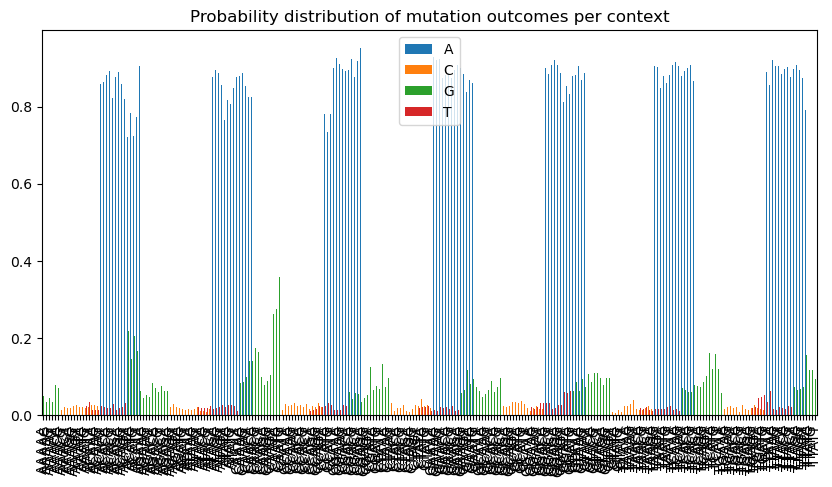

In [7]:
probs.plot(kind="bar", figsize=(10, 5))
plt.title("Probability distribution of mutation outcomes per context")
plt.show()